In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time

In [25]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
def extract_bottle(image, model, confidence_threshold=0.5, nms_threshold=0.4):
    """
    Detects a bottle in an image using a YOLO model, crops it, and returns the cropped bottle image.

    Args:
        image_path: Input image.
        model (cv2.dnn.Net): Preloaded YOLO model.
        confidence_threshold (float): Confidence threshold for YOLO detections.
        nms_threshold (float): Non-maximum suppression threshold to filter overlapping boxes.

    Returns:
        np.ndarray: Cropped image containing the detected bottle, or None if no bottle is found.
    """
    height, width = image.shape[:2]

    # YOLO input dimensions (YOLOv3/v4 typically uses 416x416 or 640x640)
    input_size = 416
    blob = cv2.dnn.blobFromImage(image, 1, (input_size, input_size), swapRB=True, crop=False)

    # Set the blob as input to the model
    model.setInput(blob)

    # Run the YOLO model
    layer_names = model.getUnconnectedOutLayersNames()
    detections = model.forward(layer_names)

    # Extract bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > confidence_threshold:
                # Scale bounding box back to the original image size
                center_x = int(obj[0])# * width)
                center_y = int(obj[1])# * height)
                box_width = int(obj[2])# * width)
                box_height = int(obj[3])# * height)

                x = int(center_x - box_width / 2)
                y = int(center_y - box_height / 2)

                boxes.append([x, y, box_width, box_height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression to filter overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imshow("Detections", image)
        cv2.waitKey(0)
    
    if len(indices) > 0:
        # Assume the first detected object is the bottle
        idx = indices[0][0] if isinstance(indices[0], list) else indices[0]
        x, y, w, h = boxes[idx]
        print(boxes[idx])

        # Crop the detected bottle from the image
        x = max(0, x)
        y = max(0, y)

        cropped_bottle = image[y:y+h, x:x+w]
        print(cropped_bottle)

        return cropped_bottle

    return None

In [22]:
from ultralytics import YOLO
import cv2
import numpy as np

def extract_bottle_ultralytics(image, model, confidence_threshold=0.5):
    """
    Detects a bottle in an image using an Ultralytics YOLO model, paints bounding boxes, 
    and optionally returns the cropped bottle image.

    Args:
        image (np.ndarray): Input image.
        model (YOLO): Preloaded Ultralytics YOLO model.
        confidence_threshold (float): Confidence threshold for YOLO detections.

    Returns:
        np.ndarray: Image with bounding boxes drawn, or None if no bottle is found.
    """
    # Run YOLO inference
    results = model.predict(source=image, conf=confidence_threshold, verbose=False)

    # Extract detection results
    detections = results[0].boxes.data.cpu().numpy()  # Bounding boxes, confidences, and class IDs
    height, width = image.shape[:2]

    # Check if any detections exist
    if len(detections) == 0:
        print("No bottles detected.")
        return None

    for detection in detections:
        # Extract bounding box and confidence
        x_min, y_min, x_max, y_max, confidence, class_id = detection

        # Only process detections with sufficient confidence
        if confidence >= confidence_threshold:
            # Draw bounding box
            cv2.rectangle(
                image,
                (int(x_min), int(y_min)),
                (int(x_max), int(y_max)),
                (0, 255, 0), 2
            )

            # Add label with confidence score
            label = f"Class {int(class_id)}, Conf: {confidence:.2f}"
            cv2.putText(
                image,
                label,
                (int(x_min), int(y_min) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2
            )

    # Display the image with bounding boxes
    cv2.imshow("Detections", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return image

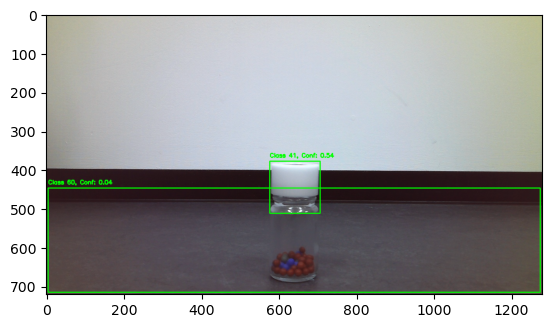

: 

In [ ]:
# Load the YOLOv8 model (pre-trained on COCO dataset or custom weights)
model = YOLO("yolov8n.pt")  # Replace with your custom model path if necessary

# Load an image
image = cv2.imread("images/img_20241111_151359.jpg")

# Detect bottles
processed_image = extract_bottle_ultralytics(image, model, confidence_threshold=0.01)

# Save or display the processed image
if processed_image is not None:
    plt.imshow(processed_image)
    plt.show()

In [11]:
# Paths
images_dir = "images"
labels_dir = "labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(416, 416))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)


In [ ]:
# Load YOLO model
model = cv2.dnn.readNetFromDarknet('yolov4.cfg', 'yolov4.weights')


# Set backend and target (if using GPU acceleration)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

image = np.array(images[0])  # Convert to NumPy array (if it's a PIL Image)
image = (image * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255] if normalized

# Extract the bottle
cropped_bottle = extract_bottle(image , model, confidence_threshold=0.1)

if cropped_bottle is not None and cropped_bottle.size > 0:
    cv2.imshow("Cropped Bottle", cropped_bottle)
    cv2.imwrite("cropped_bottle.jpg", cropped_bottle)
    cv2.waitKey(0)
else:
    print("No valid cropped image to display.")

[ WARN:0@2128.837] global net_impl.cpp:178 setUpNet DNN module was not built with CUDA backend; switching to CPU


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Shuffle the training data
X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)

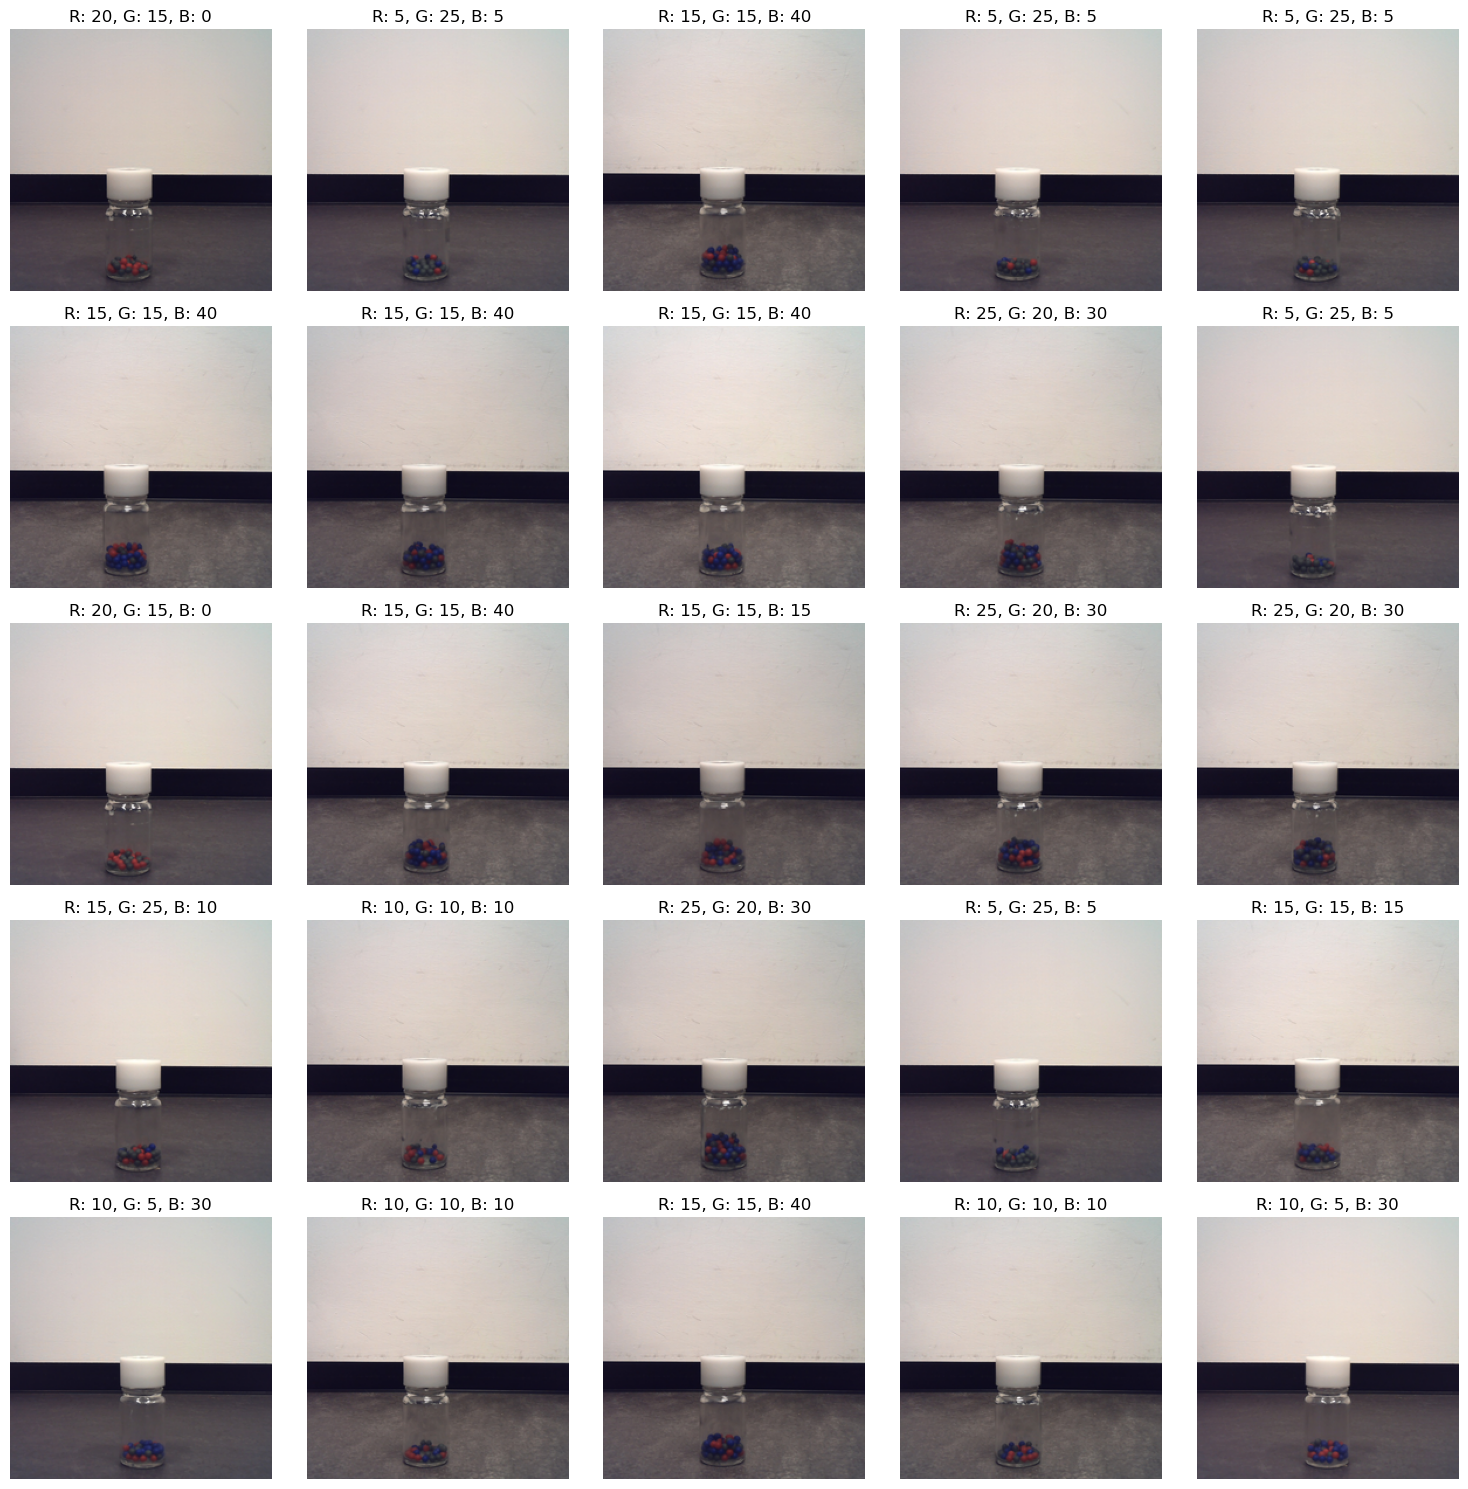

In [5]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [21]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Sequential([
    Dense(64, activation='relu'),
    Dropout(0.5),  # Dropout rate
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='linear')
])(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
# model.summary()

In [22]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the training data
datagen.fit(X_train)

In [23]:
# Training the model for 10 epochs

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 538ms/step - loss: 342.6776 - mae: 16.0625 - val_loss: 294.5051 - val_mae: 14.5963
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 307.2572 - mae: 14.5509 - val_loss: 243.9851 - val_mae: 12.6273
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 266.8017 - mae: 13.1094 - val_loss: 181.4854 - val_mae: 10.2755
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 219.4472 - mae: 11.5112 - val_loss: 127.1479 - val_mae: 8.0309
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 194.6909 - mae: 10.6393 - val_loss: 102.6930 - val_mae: 7.3538
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 154.0630 - mae: 9.8684 - val_loss: 102.3281 - val_mae: 7.3867
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 180.1093 - mae: 10.8249 - val_loss: 107.9126 - val_mae: 7.5659
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 150.6796 - mae: 9.7040 - val_loss: 104.1301 - val_mae: 7.3896
Epoch 9/10
10/10 ━━━━━━━━

In [10]:
# Save the model as a .keras file
model.save("resnet50_model_v3.keras")

In [24]:
# Training the model for 20 more epochs with all layers unfrozen

# Unfreeze the base model
for layer in base_model.layers:
    layer.trainable = True

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',       # Filepath to save the model
    monitor='val_loss',            # Metric to monitor (e.g., validation loss)
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model (weights + architecture)
    mode='min',                    # Save when 'val_loss' is minimized
    verbose=1                      # Print messages when saving
)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model with the checkpoint callback
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint_callback]  # Add the callback here
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - loss: 140.5988 - mae: 9.4578
Epoch 1: val_loss improved from inf to 111.50611, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 140.3242 - mae: 9.4372 - val_loss: 111.5061 - val_mae: 7.7197
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - loss: 136.5214 - mae: 8.9816
Epoch 2: val_loss did not improve from 111.50611
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - loss: 136.0621 - mae: 8.9829 - val_loss: 112.8584 - val_mae: 7.7328
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - loss: 136.4312 - mae: 9.3729
Epoch 3: val_loss did not improve from 111.50611
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 878ms/step - loss: 136.4795 - mae: 9.3645 - val_loss: 117.8228 - val_mae: 7.8950
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - loss: 125.5116 - mae: 8.8847
Epoch 4: val_loss did not improve from 111.50611
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 805ms/step - loss: 125.3696 - mae: 8.8748 - val_loss: 120.8103 - val_mae: 

In [11]:
# Load the saved model
model = tf.keras.models.load_model('resnet50_model_v3.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 434 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - loss: 81.8924 - mae: 7.1192
Test Loss: 81.59819793701172, Test MAE: 7.104722499847412


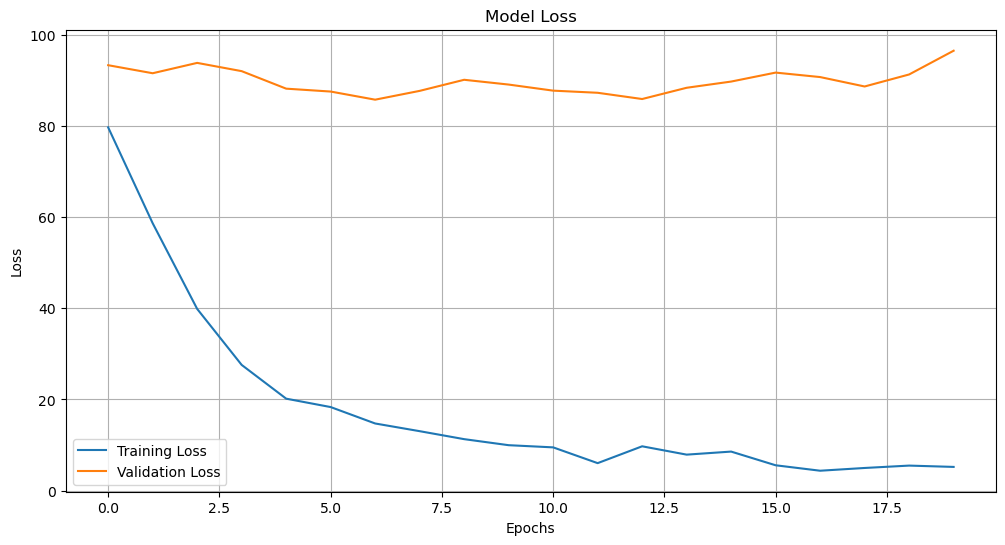

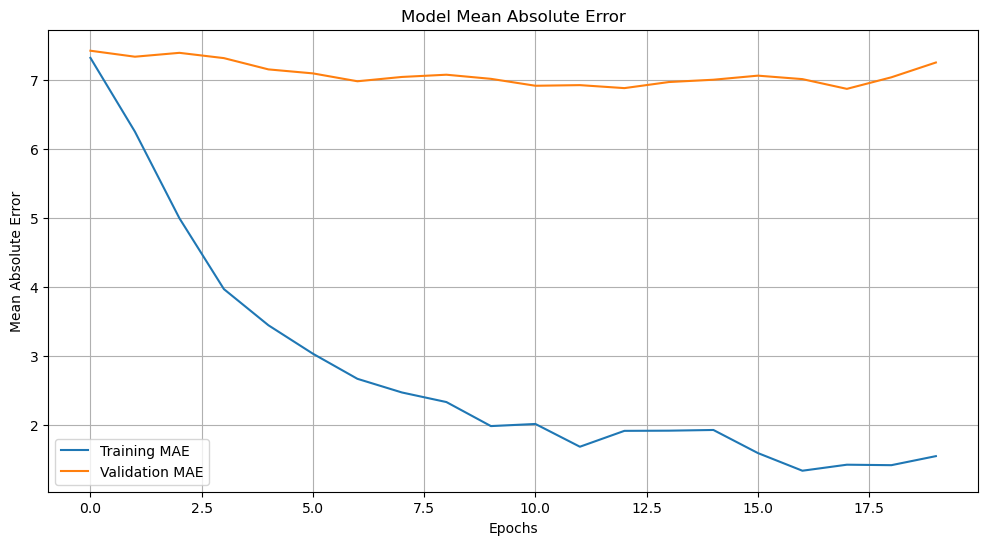

In [40]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation metrics (e.g., MAE)
plt.figure(figsize=(12, 6))
plt.plot(history_fine_tune.history['mae'], label='Training MAE')
plt.plot(history_fine_tune.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()